In [1]:
import sys
import os
from pathlib import Path

# Add src to the module search path
current_dir = os.getcwd()
src_dir = os.path.abspath(os.path.join(current_dir, '..'))

if src_dir not in sys.path:
    sys.path.append(src_dir)

In [101]:
import pandas as pd
from src.utils.config_loader import config_loader
from src.data_ingestion.loader import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

In [47]:
ROOTPATH = Path.cwd().parent
EDA_DATA_PATH = ROOTPATH / 'data' / 'eda'
RAW_DATA_PATH = ROOTPATH / config_loader.get_data_paths()['raw_data_path']
PROCESSED_DATA_PATH = ROOTPATH / config_loader.get_data_paths()['processed_data_path']

# Dataset Setup: Load, Preprocess, and Save

In [4]:
# Instatiate DataLoader
dataloader = DataLoader()

Run these cells only once

In [5]:
# # Load the raw .csv
# df = dataloader.load_raw_data(RAW_DATA_PATH / 'UserBehavior.csv')

In [6]:
# # Preprocess the raw DataFrame
# df = dataloader.preprocess_data(df)

In [7]:
# # Save preprocessed DataFrame in the format of .parquet
# dataloader.save_preprocessed_parquet(
#     df=df,
#     folder_path=PROCESSED_DATA_PATH,
#     filename='preprocessed.parquet'
# )

In [8]:
# df = pl.read_parquet(PROCESSED_DATA_PATH / 'preprocessed.parquet')
df = pd.read_parquet(PROCESSED_DATA_PATH / 'preprocessed.parquet')

# Exploratory Data Analysis

### (a) Data Inspection

In [9]:
df.head()

,user_id,item_id,category_id,behavior_type,timestamp,datetime,hour,day_of_week,date
0,1,2576651,149192,pv,1511572885,2017-11-25 01:21:25,1,5,2017-11-25
1,1,3830808,4181361,pv,1511593493,2017-11-25 07:04:53,7,5,2017-11-25
2,1,4365585,2520377,pv,1511596146,2017-11-25 07:49:06,7,5,2017-11-25
3,1,4606018,2735466,pv,1511616481,2017-11-25 13:28:01,13,5,2017-11-25
4,1,230380,411153,pv,1511644942,2017-11-25 21:22:22,21,5,2017-11-25


### (b) Summary Statistics

In [10]:
df.describe()

,user_id,item_id,category_id,timestamp,datetime,hour,day_of_week
count,9.891453e+07,9.891453e+07,9.891453e+07,9.891453e+07,98914533,9.891453e+07,9.891453e+07
mean,5.068664e+05,2.579752e+06,2.696631e+06,1.511966e+09,2017-11-29 14:36:41.987007744,9.530052e+00,3.682862e+00
min,1.000000e+00,1.000000e+00,8.000000e+01,1.511568e+09,2017-11-25 00:00:00,0.000000e+00,0.000000e+00
25%,2.523550e+05,1.295244e+06,1.320293e+06,1.511768e+09,2017-11-27 07:35:16,5.000000e+00,2.000000e+00
50%,5.038920e+05,2.580632e+06,2.671397e+06,1.511967e+09,2017-11-29 14:53:26,1.000000e+01,4.000000e+00
75%,7.608560e+05,3.862029e+06,4.145813e+06,1.512181e+09,2017-12-02 02:15:28,1.400000e+01,5.000000e+00
max,1.018011e+06,5.163070e+06,5.162429e+06,1.512345e+09,2017-12-03 23:52:41,2.300000e+01,6.000000e+00
std,2.940692e+05,1.488050e+06,1.463178e+06,2.270519e+05,NaN,5.505344e+00,2.025030e+00


### (c) Null Values

In [11]:
print("\nMissing Values per Column:")
print(df.isnull().sum())


Missing Values per Column:
user_id          0
item_id          0
category_id      0
behavior_type    0
timestamp        0
datetime         0
hour             0
day_of_week      0
date             0
dtype: int64


### (d) Data Visualization

#### User Behaviour Analysis

In [ ]:
# Calculate conversion metrics
total_users = df['user_id'].nunique()
users_with_cart = df[df['behavior_type'] == 'cart']['user_id'].nunique()
users_with_purchase = df[df['behavior_type'] == 'buy']['user_id'].nunique()

print('\nKey Conversion Metrics:')
print(f'Total unique users: {total_users:,}')
print(f'Users who added to cart: {users_with_cart:,} ({users_with_cart/total_users*100:.2f}%)')
print(f'Users who made a purchase: {users_with_purchase:,} ({users_with_purchase/total_users*100:.2f}%)')


Key Conversion Metrics:
Total unique users: 987,984
Users who added to cart: 737,393 (74.64%)
Users who made a purchase: 670,370 (67.85%)


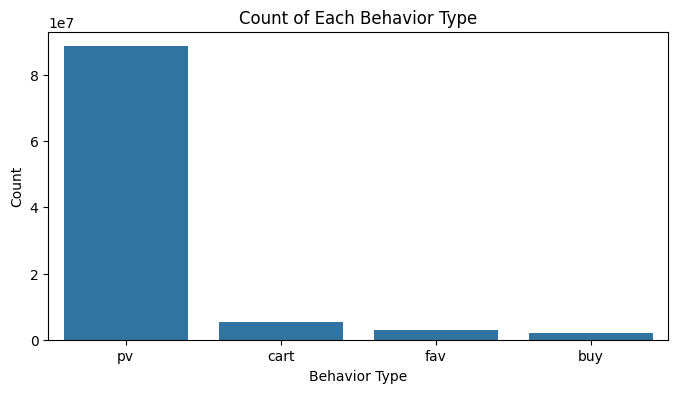

In [ ]:
if 'behavior_type' in df.columns:
    plt.figure(figsize=(8,4))
    sns.countplot(x='behavior_type', data=df, order=df['behavior_type'].value_counts().index)
    plt.title('Count of Each Behavior Type')
    plt.xlabel('Behavior Type')
    plt.ylabel('Count')
    plt.show()

#### Time-based Analysis

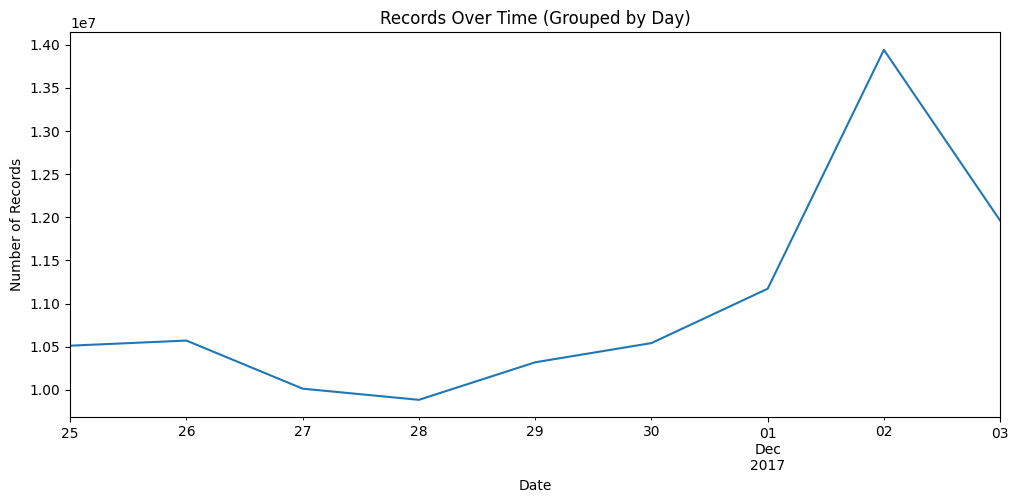

In [16]:
df.set_index('datetime', inplace=True)
daily_counts = df.resample('D').size()

plt.figure(figsize=(12,5))
daily_counts.plot()
plt.title('Records Over Time (Grouped by Day)')
plt.xlabel('Date')
plt.ylabel('Number of Records')
plt.show()

# Reset index for further analysis
df.reset_index(inplace=True)

In [ ]:
# Save DataFrame
daily_counts.to_frame(name='date_count').reset_index().to_parquet(f'{EDA_DATA_PATH / "activity_by_date.parquet"}')

<Figure size 1200x600 with 0 Axes>

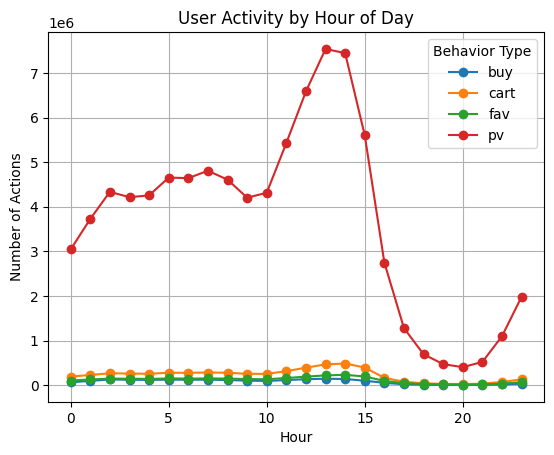

In [ ]:
# Plot activity by hourv
plt.figure(figsize=(12, 6))
hourly_activity = df.groupby(['hour', 'behavior_type']).size().unstack()
hourly_activity.plot(kind='line', marker='o')
plt.title('User Activity by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Number of Actions')
plt.legend(title='Behavior Type')
plt.grid(True)
plt.show()

In [77]:
# Save DataFrame
hourly_activity.to_parquet(f'{EDA_DATA_PATH / "activity_by_hour.parquet"}')

<Figure size 1200x600 with 0 Axes>

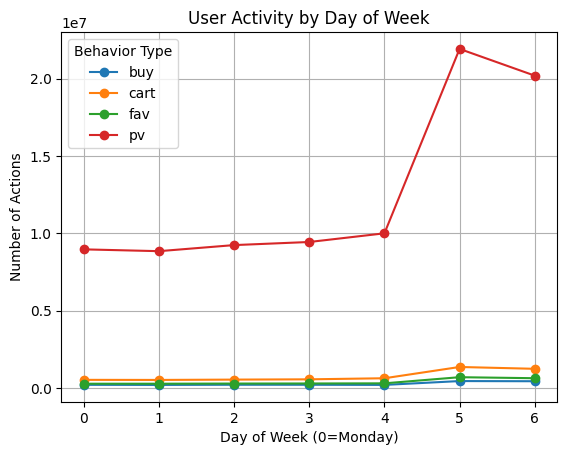

In [18]:
# Plot activity by day of week
plt.figure(figsize=(12, 6))
daily_activity = df.groupby(['day_of_week', 'behavior_type']).size().unstack()
daily_activity.plot(kind='line', marker='o')
plt.title('User Activity by Day of Week')
plt.xlabel('Day of Week (0=Monday)')
plt.ylabel('Number of Actions')
plt.legend(title='Behavior Type')
plt.grid(True)
plt.show()

In [79]:
# Save DataFrame
daily_activity.to_parquet(f'{EDA_DATA_PATH / "activity_by_day.parquet"}')

#### Item & Category Analysis

In [ ]:
# Analyze item engagement
item_stats = df.groupby('item_id').agg({
    'behavior_type': ['count', lambda x: (x == 'buy').sum()],
    'user_id': 'nunique'
}).reset_index()
item_stats.columns = ['item_id', 'total_interactions', 'purchases', 'unique_users']
item_stats['conversion_rate'] = item_stats['purchases'] / item_stats['total_interactions']

print('\nTop Items by Conversion Rate (minimum 100 interactions):')
print(item_stats[item_stats['total_interactions'] >= 100].nlargest(10, 'conversion_rate'))


Top Items by Conversion Rate (minimum 100 interactions):
         item_id  total_interactions  purchases  unique_users  conversion_rate
2690191  3352833                 102        102           100         1.000000
1508737  1880775                 125        121           122         0.968000
1984038  2472592                 141        136           134         0.964539
2546363  3173847                 172        158           134         0.918605
1509686  1881953                 180        160           140         0.888889
1132072  1411566                 271        217           131         0.800738
1425742  1777337                 118         92            83         0.779661
3405596  4244177                 158        118           122         0.746835
953805   1189521                 101         75            54         0.742574
8431       10497                 108         80            91         0.740741


In [ ]:
# Save DataFrame
item_stats.to_parquet(f'{EDA_DATA_PATH / "item_stats.parquet"}')

In [ ]:
# Category analysis
category_stats = df.groupby('category_id').agg({
    'behavior_type': ['count', lambda x: (x == 'buy').sum()],
    'user_id': 'nunique',
    'item_id': 'nunique'
}).reset_index()
category_stats.columns = ['category_id', 'total_interactions', 'purchases', 'unique_users', 'unique_items']
category_stats['conversion_rate'] = category_stats['purchases'] / category_stats['total_interactions']

print('\nCategory Statistics:')
print(category_stats.nlargest(10, 'total_interactions'))


Category Statistics:
      category_id  total_interactions  purchases  unique_users  unique_items  conversion_rate
8686      4756105             4805269      28021        415825         47692         0.005831
7608      4145813             3428569      31418        376088         68078         0.009164
4282      2355072             3329111      12297        365691         57369         0.003694
6604      3607361             3132317      12589        334864         35234         0.004019
1783       982926             3028304      24572        400104         54137         0.008114
4564      2520377             2164424       9716        301238         81026         0.004489
8767      4801426             2056335      26258        329672         48918         0.012769
2371      1320293             1933368      16948        350932         53813         0.008766
4468      2465336             1634794      13224        267714         43235         0.008089
5452      3002561             1556105 

In [85]:
# Save DataFrame
category_stats.to_parquet(f'{EDA_DATA_PATH / "category_stats.parquet"}')

#### Purchase Intent Signals

In [31]:
def analyze_item_specific_cart_to_purchase(df):
    '''
    Analyze cart-to-purchase conversion for specific items
    Returns both conversion metrics and time-to-purchase for converted items
    '''
    # Group by user_id and item_id to analyze item-specific behavior
    item_user_groups = df[df['behavior_type'].isin(['cart', 'buy'])].groupby(['user_id', 'item_id'])
    
    conversion_times = []
    conversion_stats = {
        'cart_converted': 0,  # items that went from cart to purchase
        'cart_abandoned': 0,  # items that were carted but never purchased
        'direct_purchase': 0  # items purchased without being carted first
    }
    
    for (user, item), actions in item_user_groups:
        actions_sorted = actions.sort_values('datetime')
        cart_times = actions_sorted[actions_sorted['behavior_type'] == 'cart']['datetime']
        buy_times = actions_sorted[actions_sorted['behavior_type'] == 'buy']['datetime']
        
        if len(cart_times) > 0:
            if len(buy_times) > 0:
                # Found a conversion - calculate time from first cart to first purchase
                conversion_time = (buy_times.iloc[0] - cart_times.iloc[0]).total_seconds() / 3600
                conversion_times.append({
                    'user_id': user,
                    'item_id': item,
                    'hours_to_purchase': conversion_time
                })
                conversion_stats['cart_converted'] += 1
            else:
                conversion_stats['cart_abandoned'] += 1
        elif len(buy_times) > 0:
            conversion_stats['direct_purchase'] += 1
    
    return pd.DataFrame(conversion_times), conversion_stats

In [32]:
# Run the analysis
conversion_df, stats = analyze_item_specific_cart_to_purchase(df)

In [98]:
# Save DataFrame
conversion_df.to_parquet(f'{EDA_DATA_PATH / "conversion_per_user.parquet"}')

stats_df = pd.DataFrame(list(stats.items()), columns=['event_type', 'count'])
stats_df.to_parquet(f'{EDA_DATA_PATH / "conversion_stats.parquet"}')

In [33]:
# Print summary statistics
print('Cart-to-Purchase Conversion Statistics:')
print('-' * 50)
total_cart_events = stats['cart_converted'] + stats['cart_abandoned']
conversion_rate = (stats['cart_converted'] / total_cart_events * 100) if total_cart_events > 0 else 0

print(f'Items added to cart and purchased: {stats["cart_converted"]:,}')
print(f'Items added to cart but not purchased: {stats["cart_abandoned"]:,}')
print(f'Items purchased directly (no cart): {stats["direct_purchase"]:,}')
print(f'Cart-to-Purchase Conversion Rate: {conversion_rate:.2f}%')

Cart-to-Purchase Conversion Statistics:
--------------------------------------------------
Items added to cart and purchased: 342,975
Items added to cart but not purchased: 4,981,496
Items purchased directly (no cart): 1,567,155
Cart-to-Purchase Conversion Rate: 6.44%


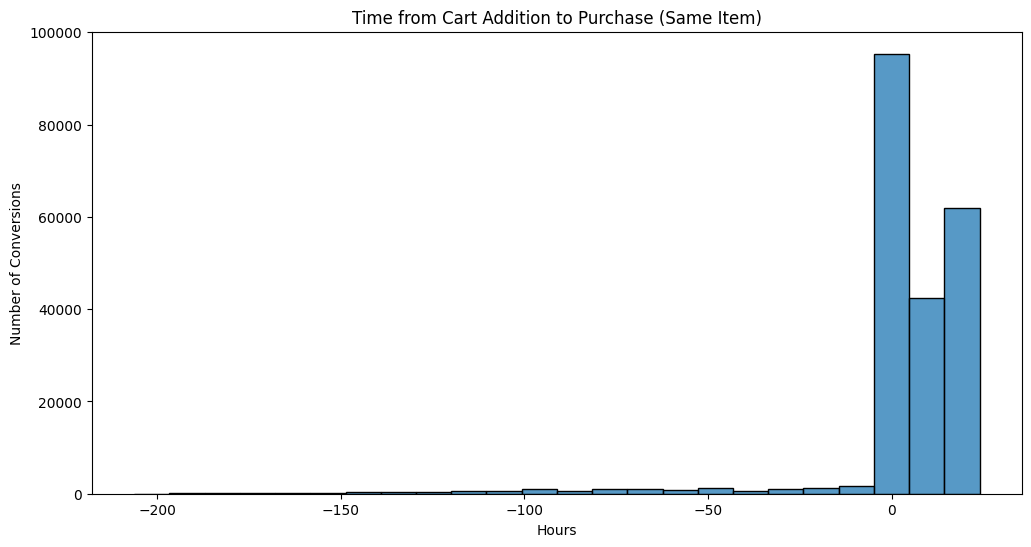

In [34]:
# Visualize distribution of purchase times for converted items
plt.figure(figsize=(12, 6))
sns.histplot(
    data=conversion_df[conversion_df['hours_to_purchase'] < 24],
    x='hours_to_purchase',
    bins=24
)
plt.title('Time from Cart Addition to Purchase (Same Item)')
plt.xlabel('Hours')
plt.ylabel('Number of Conversions')
plt.show()

In [37]:
# Analyze conversion rate by category
item_category_map = df[['item_id', 'category_id']].drop_duplicates()
conversion_df = conversion_df.merge(item_category_map, on='item_id')
category_conversion = conversion_df.groupby('category_id')['hours_to_purchase'].agg(['count', 'mean', 'median'])
print('Category-wise Cart-to-Purchase Time (hours):')
print(category_conversion.sort_values('count', ascending=False).head(10))

Category-wise Cart-to-Purchase Time (hours):
             count       mean     median
category_id                             
4756105       8125  26.226995  16.910000
4145813       8028  27.967325  18.327917
2735466       6672  25.810206  18.301250
4801426       6465  26.917690  19.213056
982926        6288  25.932492  17.935833
1464116       5337  28.300196  19.430556
2885642       4868  23.978455  14.700972
1320293       4164  26.064340  18.317500
2640118       3994  24.504515  17.665694
3002561       3813  26.860318  18.483889


In [ ]:
# Save DataFrame
category_conversion.to_parquet(f'{EDA_DATA_PATH / "category_conversion.parquet"}')